# Simulation

[![Click and Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/metadriverse/metaurban/blob/main/documentation/source/system_design.ipynb)


After going through this section, you will learn to customize an simulation environment with developer APIs. Before this, let's discuss what a simulation is.

> *Simulation is the process of creating a model of a real or imagined system and then conducting experiments with this model. The purpose is usually to understand how the system works, to predict its behavior under different conditions, or to develop strategies for its operation. This is akin to creating a miniature, controllable version of a complex system in a virtual or conceptual space, where you can observe, experiment, and understand the outcomes without having to interact with the real system. This approach is invaluable in scenarios where real-world experimentation is impractical, dangerous, or impossible.*
> 
> &mdash; *ChatGPT4*

The mathematical definition of simulation is a **transition probability function**, $P(s' | s)$, which gives the probability of transitioning to state $s'$ given current state $s$.
For a deterministic simulation, the **transition probability function** can be simplified as a **transition function** $s' = \mathcal T (s) $. It means the state $s$ will always be transferred to the state $s'$. MetaUrban is a deterministic simulator and thus outcomes across repetitive runs will be the same if initial conditions and the random seed are identical. Therefore, MetaUrban is defined with the **state space** $S$ and **the transition function** $\mathcal T$. 

As an autonomous driving simulator, for each state $s \in S$, it consists of all static objects' information like the map structure and all dynamic objects' properties, i.e. positions, headings, velocities, and so on. 
As the static objects won't change throughout the whole simulated episode, i.e. map structure, the new state $s'$ produced by **transition function** mainly differentiates $s$ in the following aspects: 
- properties of existing dynamic objects are updated
- properties of new dynamic objects are included if any new dynamic objects are spawned
- properties of existing dynamic objects are deleted if any dynamic objects should be recycled

Since the state space is defined and constrained to the 3D physics world, the work remaining for developers to build a driving simulation is to compose the **transition function** completing the aforementioned three tasks. Concretely, if the *openai-gym* style APIs are used, the three tasks should happen in the `env.step()` and be repeated again and again to simulate a driving scene. The following two consecutive frames illustrate the role of **transition function** in MetaUrban. The cars in black, red, and purple boxes show recycling, spawning, and actuation respectively.

## System Design

To understand the mechanism of MetaUrban, let's first delve into the `env.step()`. The `step()` function in all environments is inherited from `BaseEnv.step()`, which has the following implementation.

In [1]:
from metaurban.utils import print_source
from metaurban.envs.base_env import BaseEnv
print_source(BaseEnv.step)

def step(self, actions: Union[Union[np.ndarray, list], Dict[AnyStr, Union[list, np.ndarray]], int]):
    actions = self._preprocess_actions(actions)  # preprocess environment input
    engine_info = self._step_simulator(actions)  # step the simulation
    while self.in_stop:
        self.engine.taskMgr.step()  # pause simulation
    return self._get_step_return(actions, engine_info=engine_info)  # collect observation, reward, termination



The first line is for preprocessing the `actions`, which is the external input, while the last line is for collecting observations and passing them outside the environment. Thus the simulator is stepped by `_step_simulation` and the basic 3 procedures for simulating the driving scene are as follows.

In [2]:
print_source(BaseEnv._step_simulator)

def _step_simulator(self, actions):
    # prepare for stepping the simulation
    scene_manager_before_step_infos = self.engine.before_step(actions)
    # step all entities and the simulator
    self.engine.step(self.config["decision_repeat"])
    # update states, if restore from episode data, position and heading will be force set in update_state() function
    scene_manager_after_step_infos = self.engine.after_step()

    # Note that we use shallow update for info dict in this function! This will accelerate system.
    return merge_dicts(
        scene_manager_after_step_infos, scene_manager_before_step_infos, allow_new_keys=True, without_copy=True
    )



As we use the bullet engine for underlying physics simulation, the `self.engine.step()` is actually a wrapper for repeatedly executing `BulletWorld.doPhysics(dt, 1, dt)`, where `dt` is the minimal sub-timestep for integration. A smaller `dt` produces a more accurate simulation. The `doPhysics()` is repeated by `decision_repeat` times and finally, the simulation will forward `dt * decision_repeat` seconds after calling `engine.step()`. This period is set to `0.1s` by default with `dt=0.02` and `decision_repeat=5`. For example, the vehicle's speed will be increased to $5\ m/s$ at state $s'$ if it has a $4.9\ m/s$ speed with a $1m\ /s^2$ acceleration before advancing the simulation. 

Before advancing the physics world, there may be some preparations required. For example, if the external input contains signals for controlling a certain vehicle, the steering angles and the throttle value should be set on the target vehicle before stepping it. Thus all these preprocessings are finished by calling `self.engine.before_step()`. 

Similarly, through `self.engine.after_step()`, we can post-process, calculate, and collect some information after advancing the simulation. For example, we usually detect if the vehicle collides with buildings, humans, and other vehicles in the post-processing. In addition, the state update can be finished in the `after_step` stage as well if these properties are pre-calculated somewhere. For example, if we are replaying vehicle trajectories collected in the real world, we can set the velocity and positions of vehicles in this stage directly. **Note: the `decision_repeat` DOES NOT take effect in `engine.before_step` and `engine.after_step`**.

If we dive deeper to check the `engine.before_step()`, `engine.step()`, and `engine.after_step()`. We will find that all three functions share the same structure. Take the `before_step()` function as the example. It sequentially executes `mgr.before_step()` for each manager. 
```python
def before_step(self):
    for mgr in managers.values():
        # or mgr.step() / mgr.after_step() for engine.step() / engine.after_step(), respectively
        mgr.before_step() 
```

In addition, a simulation needs an initial state as the starting point of everything.
This is provided by calling `env.reset()`.
What happens in `env.reset()` is similar to `env.step()`: sequentailly calling `before_reset()`, `reset()`, `after_reset()` for all managers.

In a nutshell, the simulation and state transition are controlled and defined by chaining a set of managers. How to execute managers to do simulation is demonstrated in the following flow chart (supposing there are 2 managers in total and the repetition *N*=config["decision_repeat"]).

<img src="figs/execution_queue.png" width="800" class="center">


This mechanism lays the foundation for building the simulation. As a developer, building a new environment is actually building a set of managers inherited from `BaseManager` with several functions overridden.

## Manager

The transition function is implemented as a set of managers that concretely defines when to spawn or recycle objects and how to actuate existing objects. 
Thus different manager combinations result in different simulation results. 
MetaUrban composes different simulation environments by varying the managers, which are plugins essentially.
To make a manager, we need to override the three step-related functions: `before_step()`, `step()`, and `after_step`, and two reset-related functions: `before_reset` and `reset`.
After this, we need to register them in `env.setup_engine`. The registered manager can be accessed by `env.engine.managers[manager_id]` or `env.manager.manager_id`. 

### Step
Let's discuss the step-related ones. Most of the time, we don't need to override the `step()` function as advancing physics is executed by the physics engine already. Only override it when you have a different kinematic/dynamic model for a certain object. For example, if you want to use a customized bicycle model as the kinematics model of a vehicle, you need to put something into the `step()` function and calculate where the car is going to move given steering, throttle, position, heading, and velocity. Therefore, the key interface to developing a manager is `before_step()` and `after_step()`.

Let's create an example to illustrate what we can do with these two developer APIs. In the following example, a vehicle is generated at timestep 40, and recycled at timestep 100. In this period, the vehicle keeps turning left.

In [3]:
from metaurban.envs import SidewalkStaticMetaUrbanEnv
from metaurban.manager import BaseManager
from metaurban.component.vehicle.vehicle_type import DefaultVehicle
from IPython.display import clear_output, Image

class ExampleManager(BaseManager):
    def __init__(self):
        super(ExampleManager, self).__init__()
        self.generated_v = None
        self.generate_ts = 40
        self.recycle_ts = 100
        
    def before_step(self):
        if self.generated_v:
            self.generated_v.before_step([0.5, 0.4]) # set action
        

    def after_step(self):
        if self.episode_step == self.generate_ts:
            self.generated_v = self.spawn_object(DefaultVehicle, 
                                  vehicle_config=dict(), 
                                  position=(10, 0), 
                                  heading=0)
        elif self.episode_step == self.recycle_ts:
            self.clear_objects([self.generated_v.id])
            self.generated_v = None
        elif self.generated_v:
            self.generated_v.after_step()

class ExampleEnv(SidewalkStaticMetaUrbanEnv):

    def setup_engine(self):
        super(ExampleEnv, self).setup_engine()
        self.engine.register_manager("exp_mgr", ExampleManager())

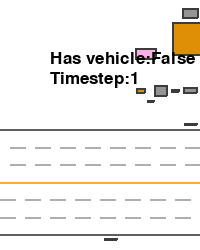

In [5]:
env = ExampleEnv(dict(map="S", object_density=0.1))
try:
    env.reset()
    for _ in range(120):
        env.step([0, 0]) # ego car is static
        env.render(mode="topdown", 
                   window=False,
                   screen_size=(200, 250),
                   camera_position=(20, 20),
                   screen_record=True,
                   text={"Has vehicle": env.engine.managers["exp_mgr"].generated_v is not None,
                         "Timestep": env.episode_step})
    env.top_down_renderer.generate_gif()
finally:
    env.close()
    clear_output()
Image(open("demo.gif", 'rb').read())

The simulation can be made more complex if we turn the generation rules and recycling rules defined in `after_step()` into complicated ones including but not limited to:
- generate more vehicles
- randomly choosing spawn points
- randomly selecting vehicle types
- recycling objects when they arrive at the destination or a crash happens
- assign complex policies to control the spawned objects to increase the automation level
- and so on ...

### Reset
In the previous example, no initialization is executed as we didn't override the `before_reset()` and `reset()` functions. 
But these two functions are important if we are going to simulate a set of scenarios instead of one environment.
For switching to a new scenario whenever `env.reset()` is executed, we need to do two things:
- clear objects created in the previous episode, making the scene empty
- generate new objects and compose a new scenario

Thus the `manager.before_reset()` and `reset()` are for these aims respectively.
Usually, we don't need to modify the `before_reset()` and just use the one from the base class.
This is because all objects created by `spawn_object()` will be recorded in `manager.spawned_objects`, which will be cleared by `BaseManager.before_reset()` when initializing a new episode.
Thus users don't need to manage the object destroy manually. 
If we are going to spawn a traffic cone when the scene is created, we can do related operations in `ExampleManager.reset()`. That's all!

In practice, we use managers to manage almost everything such as maps, traffic, pedestrians, traffic lights, and so on.
You can find a lot of examples under the directory ```metaurban/managers```.

### Priority
When multiple managers work together, it is necessary to determine the execution sequence. It can be decided by the `PRIORITY` property, which is a class property and needs to be specified when creating your manager. Managers with lower values have higher priorities. The code exemplifies this.

In [6]:
from metaurban.envs import SidewalkStaticMetaUrbanEnv
from metaurban.manager import BaseManager

class Manager1(BaseManager):
    PRIORITY = 10
    
    def reset(self):
        print("Reset Manager 1")

class Manager2(BaseManager):
    PRIORITY = 20

    def reset(self):
            print("Reset Manager 2")

class CompareEnv(SidewalkStaticMetaUrbanEnv):

    def setup_engine(self):
        super(CompareEnv, self).setup_engine()
        self.engine.register_manager("mgr_1", Manager1())
        self.engine.register_manager("mgr_2", Manager2())

env = CompareEnv(dict(map="S", log_level=50, object_density=0.1))
try:
    env.reset()
finally:
    env.close()

Reset Manager 1
Reset Manager 2


*Some may ask *why we need the abstraction: manager. Is it redundant, making the system complex?*. 
Well, if this is a simple car-driving environment like *gym car-racing*, such an abstraction is indeed not necessary.
However, we introduce extra abstraction to increase the system's extensibility and atomicity.
As a result, functionalities are isolated clearly and won't interfere with each other.
The reason is the same as why we separate code into several files and wrap it with classes given that we can actually put all things in a single file with thousands of lines.*

## Object
As stated before, a manager is responsible for managing the creation, movements, and recycling of objects.
In MetaUrban, objects can be simply considered as vehicles, pedestrians, and almost all traffic participants.
However, the concept of object can go beyond these concrete entities. 
A roadblock and a map can be an object as well as long as they are managed by managers.

Existing objects in a manager can be accessed with `manager.spawned_objects`.
This dictionary allows one to monitor the status of objects created by this manager and access these objects with their ID.
Furthermore, it allows the manager to automatically destroy objects generated in the finished episode when creating a new one.
Three basic operations can be applied to modify or access this dictionary: `spawn_object`, `get_objects`, and `clear_objects`.

### Spawn Object
For creating an object, we use the API `manager.spawn_object`. It takes as input the object class and the parameters required for creating an instance from this class and returns the created instance. The syntax is like:
```python
obj = self.spawn_object(object_class, parameter_1=p_1, parameter_2=p2)
```
The obj created in this way is the same as:
```python
obj = object_class(parameter_1=p_1, parameter_2=p2) 
```
The reason we use the `spawn_object` to create object instances is that this function will do some latent optimizations speeding up the object creation.
It also logs the creation data in the record system, so we can replay the spawning behavior when replaying a logged scenario. 
In addition, it sets the random_seed for an object to make sure the outcome of a simulation can be reproduced.
It is worth noting that the `spawn_object` function only accepts **keyword arguments** to ensure the parameters are specified successfully.

### Clear Object
In one episode, we may want to delete some objects from the scene if it is finished. In this case, the `manager.clear_objects()` can be used.
Similar to `get_objects`, it is allowed to destroy a list of objects with certain IDs or meeting specific conditions.

Actually, the object destroyed in this way is still kept in the memory. It is stored in a dead object pool.
When the same type of objects are going to spawn, we can activate them directly, which accelerates the object spawning.
However, users can still set the `destory=True` to fully remove this object from the memory.
The following example shows how to clear all M-type vehicles managed by the `traffic_manager`.

### Object APIs in Engine 
Actually, the three object APIs are wrappers for `engine.spawn_object`, `engine.get_objects()`, and `engine.clear_objects()`.
The difference is the object APIs in the manager additionally modify the `manager.spawned_objects`.
Therefore, developers can call the engine-based object APIs for managing objects as well.
However, keep in mind that cross-manipulation is prohibited. 
Objects created by manager-based object API should be recycled by `manager.clear_objects()`, while those created by `engine.spawn_object` must be recycled by `engine.clear_objects()`. Similarly, objects created by manager 1 can not be recycled by manager 2.
These behaviors will induce bugs. 

All generated objects no matter by which manager it is created are recorded in `engine._spawned_objects`. Thus the engine-based object API will traverse all objects instead of a specific manager-created ones when getting and clearing objects. The engine also has underlying mechanisms to detect and avoid memory leaks like checking if all objects are cleared when creating a new scenario. Despite this, we still recommend using managers to manage your scene, which can be viewed as a "sub-engine" with complex optimization in hiding.


## Policy
The policy is usually associated with objects, especially those whose properties need to be changed.
For example, the throttle and steering of a vehicle have to be changed to move toward the destination.
How to change these properties can be determined by policies inherited from `BasePolicy` with the `policy.act()` overridden.
Thus calling `policy.act()` is to make one decision according to the policy. 
This function is supposed to return some decisions for an object such as control signals for a vehicle.
Here, we discuss APIs for creating and accessing policies.
For customizing a policy, please refer to <a href="action.html#customization">Policy Customization</a>. 

### APIs
A policy can be added for an object through `manager.add_policy`.
Similar to `spawn_object()`, typical usage of this API is as follows.
```python
policy = add_policy(object_id,  PolicyClass, policy_argument_1, policy_argument_2) 
```
It is the same as
```python
policy = PolicyClass(policy_argument_1, policy_argument_2)
```
By having the `object_id` recorded by the engine, we can access the policy of an object everywhere.
A policy for the corresponding object can be accessed by `engine.get_policy(object_id)` or `manager.get_policy(object_id)`. The latter one is implemented by calling the former one, so these two methods have no difference. Whenever an object is cleared through `engine.clear_objects` or `manager.clear_objects`, the policy associated with it will be cleared and destroyed as well.

### Example
This example demonstrates how to add a policy for an object generated and managed by a manager.
We added an IDMPolicy for the generated object, so it can drive toward the destination.

In [10]:
from metaurban.policy.idm_policy import IDMPolicy
from metaurban.envs import SidewalkStaticMetaUrbanEnv
from metaurban.manager import BaseManager
from metaurban.component.vehicle.vehicle_type import DefaultVehicle
from IPython.display import clear_output, Image

class MovingExampleManager(BaseManager):
            
    def before_step(self):
        for id, obj in self.spawned_objects.items():
            p = self.get_policy(id)
            obj.before_step(p.act()) # set action

    def reset(self):
        obj = self.spawn_object(DefaultVehicle, 
                          vehicle_config=dict(), 
                          position=(10, 0), 
                          heading=0)
        self.add_policy(obj.id, IDMPolicy, obj, self.generate_seed())

    def after_step(self):
        for obj in self.spawned_objects.values():
            obj.after_step()
        if self.episode_step == 180:
            self.clear_objects(list(self.spawned_objects.keys()))

class MovingExampleEnv(SidewalkStaticMetaUrbanEnv):

    def setup_engine(self):
        super(MovingExampleEnv, self).setup_engine()
        self.engine.update_manager("traffic_manager", MovingExampleManager()) # replace existing traffic manager

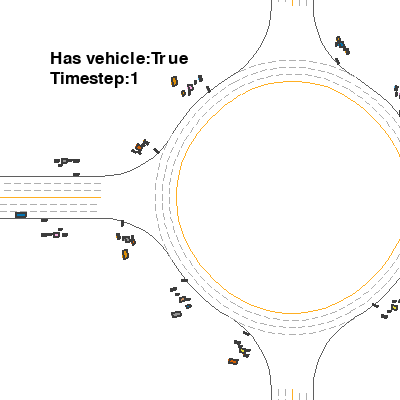

In [11]:
env = MovingExampleEnv(dict(map="O", object_density=0.1, traffic_density=0.1))
try:
    env.reset()
    for _ in range(200):
        env.step([0, 0]) # ego car is static
        env.render(mode="topdown", 
                   window=False,
                   screen_size=(400, 400),
                   camera_position=(100, 7),
                   scaling=2,
                   screen_record=True,
                   text={"Has vehicle": bool(len(env.engine.traffic_manager.spawned_objects)),
                         "Timestep": env.episode_step})
    assert env
    env.top_down_renderer.generate_gif()
finally:
    env.close()
    clear_output()
Image(open("demo.gif", 'rb').read())

## Config
Commonly, we want to have some parameters to adjust the properties of the manager, such as the vehicle generation timestep and recycling timestep in the previous example.
Rather than hardcoding them in the class, we can expose them outside, so users can change these properties through the config system.
The following code is modified based on the manager example, the differences are marked with annotations.

In [12]:
from metaurban.envs import SidewalkStaticMetaUrbanEnv
from metaurban.manager import BaseManager
from metaurban.component.vehicle.vehicle_type import DefaultVehicle
from IPython.display import clear_output, Image

class ExampleManager(BaseManager):
    def __init__(self):
        super(ExampleManager, self).__init__()
        self.generated_v = None

        # ===== Access the parameters in engine.global_config =====
        self.generate_ts = self.engine.global_config["generate_timestep"]
        self.recycle_ts = self.engine.global_config["recycle_timestep"]
        
    def before_step(self):
        if self.generated_v:
            self.generated_v.before_step([0.5, 0.4]) # set action
        

    def after_step(self):
        if self.episode_step == self.generate_ts:
            self.generated_v = self.spawn_object(DefaultVehicle, 
                                  vehicle_config=dict(), 
                                  position=(10, 0), 
                                  heading=0)
        elif self.episode_step == self.recycle_ts:
            self.clear_objects([self.generated_v.id])
            self.generated_v = None
        elif self.generated_v:
            self.generated_v.after_step()

# ===== This environment has two more configs than the SidewalkStaticMetaUrbanEnv =====
EXAMPLE_ENV_CONFIG = dict(generate_timestep=40,
                          recycle_timestep=100)


class ExampleEnv(SidewalkStaticMetaUrbanEnv):

    # ===== Register them by merging them with the config of SidewalkStaticMetaUrbanEnv
    @classmethod
    def default_config(cls):
        cfg = super(ExampleEnv, cls).default_config()
        cfg.update(EXAMPLE_ENV_CONFIG)
        return cfg

    def setup_engine(self):
        super(ExampleEnv, self).setup_engine()
        self.engine.update_manager("traffic_manager", ExampleManager())

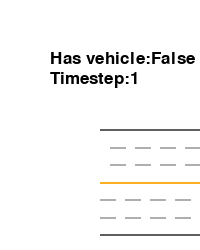

In [14]:
# ===== Set parameters for ExampleManager ===== 
env = ExampleEnv(dict(generate_timestep=80,
                      recycle_timestep=200, 
                      map="S",
                      object_density=0.1,
                      traffic_density=0.1))
try:
    env.reset()
    for _ in range(220):
        env.step([0, 0]) # ego car is static
        env.render(mode="topdown", 
                   window=False,
                   screen_size=(200, 250),
                   camera_position=(0, 20),
                   screen_record=True,
                   text={"Has vehicle": env.engine.managers["traffic_manager"].generated_v is not None,
                         "Timestep": env.episode_step})
    env.top_down_renderer.generate_gif()
finally:
    env.close()
    clear_output()
Image(open("demo.gif", 'rb').read())

In this example, we add two parameters into the environment config and access their values in the `ExampleManager` through `engine.global_config`.
As in each process, the `engine` is a global variable and a singleton. Thus we can access it everywhere via `metaurban.engine.engine_utils.get_engine()`.
With the engine, we can access the `global_config` as well. In this example, the engine is accessed by calling `manager.engine`, which is actually a wrapper for `get_engine()`.
Moreover, the config acquired by `engine.global_config` is the same as the `env.config`. Both of them point to the same config dict instance.
Therefore, with a global config dict, we can access all parameters everywhere, exempting the need for designing the function argument list and passing parameters when creating managers.

In [13]:
from metaurban.engine import get_engine
try:
    env.reset()
    clear_output()
    claim = env.config is env.engine.global_config is get_engine().global_config
    assert claim
    print(claim)
finally:
    env.close()

True


More information about the usage of config system and config lists for specific environment can be found at [Configuration](config_system.ipynb).